# MobileNet SSD Implementation and Training.

## Generate the train dataset and validate dataset.

In [1]:
from get_data_from_xml import XML_preprocessor
from ssd_utils import BBoxUtility
import pickle

dataset = XML_preprocessor('F:\\VOC2012\\Annotations\\')
gt = dataset.data

keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

num_val = len(val_keys)

bbox_util = BBoxUtility(21)
# bbox_util = BBoxUtility(21, pickle.load(open('prior_boxes_VOC_512_mobileNet_ssd.pkl', 'rb')))

In [2]:
from ssd.utils import Generator

gen = Generator(
    gt=gt,
    bbox_util=bbox_util,
    batch_size=4,
    path_prefix='F:\\VOC2012\\JPEGImages\\',
    train_keys=train_keys,
    val_keys=val_keys,
    image_size=(512, 512, 3),
    do_crop=False
)

## Build the model.

In [3]:
from MobileNet_SSD import build_model

model = build_model(input_shape=(512, 512, 3), classes=21)

Load parameters from pre-train model.

In [4]:
# model.load_weights('../model/VOC/VOC_MobileNet_53.50.h5', by_name=True)
model.load_weights('checkpoints/high/VOC_512_weights.16-3.46.hdf5', by_name=True)

Transfer Learning.

In [5]:
freeze = [
    'input_1', 'conv1', 'conv1_bn', 'conv1_relu',
    'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu',
    'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu',
    'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu',
    'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu',
    'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu',
    'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu',
    'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu',
    'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu',
    'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu',
    'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu',
    'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu',
    'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu',
    'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu'
]

# for L in model.layers:
#     if L.name in freeze:
#         L.trainable = False

## Train the model.

In [6]:
from tensorflow import keras

def schedule(epoch):
    initial_lrate = 3e-3
    drop = 0.9
    return initial_lrate * (drop ** (epoch))

callbacks = [
    keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
    # keras.callbacks.LearningRateScheduler(lambda epoch, decay=0.9: 3e-3 * (decay ** epoch))
    keras.callbacks.LearningRateScheduler(schedule)
]

In [7]:
from ssd_training import MultiboxLoss

optim = keras.optimizers.Adam()

model.compile(
    optimizer=optim,
    loss=MultiboxLoss(21, neg_pos_ratio=2.0).compute_loss
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [8]:
# model.fit(
#     gen.generate(True),
#     steps_per_epoch=100,
#     epochs=10,
#     verbose=1,
#     callbacks=callbacks,
#     validation_data=gen.generate(False),
#     validation_steps=30,
#     # use_multiprocessing=True,
#     # workers=1
# )

## Evaluate the model using one image.

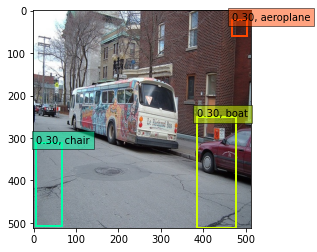

In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# img = image.load_img('F:\\VOC2012\\JPEGImages\\2007_000738.jpg', target_size=(512, 512))
# img = image.load_img('F:\\VOC2012\\JPEGImages\\2011_001663.jpg', target_size=(512, 512))
img = Image.open('F:\\VOC2012\\JPEGImages\\2007_005262.jpg')
img = img.resize((512, 512), Image.ANTIALIAS)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)



pred = model.predict(img)

result = bbox_util.detection_out(pred)



import matplotlib.pyplot as plt

voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Parse the outputs.
det_label = result[0][:, 0]
det_conf  = result[0][:, 1]
det_xmin  = result[0][:, 2]
det_ymin  = result[0][:, 3]
det_xmax  = result[0][:, 4]
det_ymax  = result[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.29]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

# img = img[0,:,:,:]
plt.imshow(img[0,:,:,:] / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[2]))
    ymin = int(round(top_ymin[i] * img.shape[1]))
    xmax = int(round(top_xmax[i] * img.shape[2]))
    ymax = int(round(top_ymax[i] * img.shape[1]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()

In [10]:
# gt

g = gen.generate()
